# Data Exploration
We will do our data explorationg in here, using the processed and saved dictionaries so that we don't have to parse through the data files every time we want to analyze it.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
with open('FinalTimeSeriesDataset.pickle', 'rb') as file: 
    dataset, stationslist = pickle.load(file, encoding='latin1')

In [3]:
#remove stations with problematic data
#for station in stationslist:
#    if (station == 'WALL ST') or (station == 'SUTPHIN BLVD') or (station == 'METROPOLITAN AV')\
#        or (station == 'NEVINS ST') or (station == 'KINGSTON-THROOP'):
#        del dataset[station]
#stationslist = list(dataset.keys())[:]

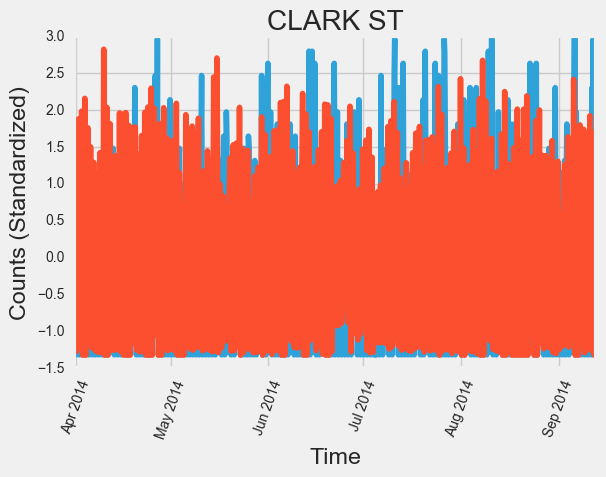

In [4]:
station = 'CLARK ST'
time = dataset[station].times
pickups = dataset[station].pickups
exits = dataset[station].exits
for count in range(5):
    #We need to standardize the two time series so they can be compared and correlated properly
    pickups = (pickups - pickups.mean())/pickups.std()
    exits = (exits - exits.mean())/exits.std()
    #Now we need to remove outliers (greater than 3-sigma) that could be due to bad data
    pickups[pickups.apply(abs) > 3] = 0
    exits[exits.apply(abs) > 3] = 0
#plotting
plt.xticks(rotation=70)
plt.plot(time, pickups, time, exits);
plt.title(station);
plt.xlabel('Time');
plt.ylabel('Counts (Standardized)');

In [5]:
Correlations = {}
for station in dataset:
    pickups = dataset[station].pickups
    exits = dataset[station].exits
    for count in range(5):
        #We need to standardize the two time series so they can be compared and correlated properly
        pickups = (pickups - pickups.mean())/pickups.std()
        exits = (exits - exits.mean())/exits.std()
        #Now we need to remove outliers (greater than 3-sigma) that could be due to bad data
        pickups[pickups.apply(abs) > 3] = 0
        exits[exits.apply(abs) > 3] = 0
    Corr = pd.Series.corr(pickups,exits)
    if Corr > 0:
        Correlations[station] = Corr

In [6]:
#Graphing
df_corr = pd.DataFrame({'Station' : list(Correlations.keys()), 'Correlation' : list(Correlations.values())});df_corr

,Correlation,Station
0,0.121292,HALSEY ST
1,0.255374,CANAL ST
2,0.356451,JEFFERSON ST
3,0.075387,CLEVELAND ST
4,0.058186,PARSONS BLVD
5,0.339000,STEINWAY ST
6,0.128177,PENNSYLVANIA AV
7,0.151287,JUNIUS ST
8,0.104385,STERLING ST
9,0.041979,SIMPSON ST


In [7]:
df_corr = df_corr.sort_values(['Correlation'], ascending=False)

In [11]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=df_corr.Correlation,
            y=df_corr.Station,
            orientation = 'h',
            
        )]

py.iplot(data, filename='horizontal-bar')


(0.0, 0.7)

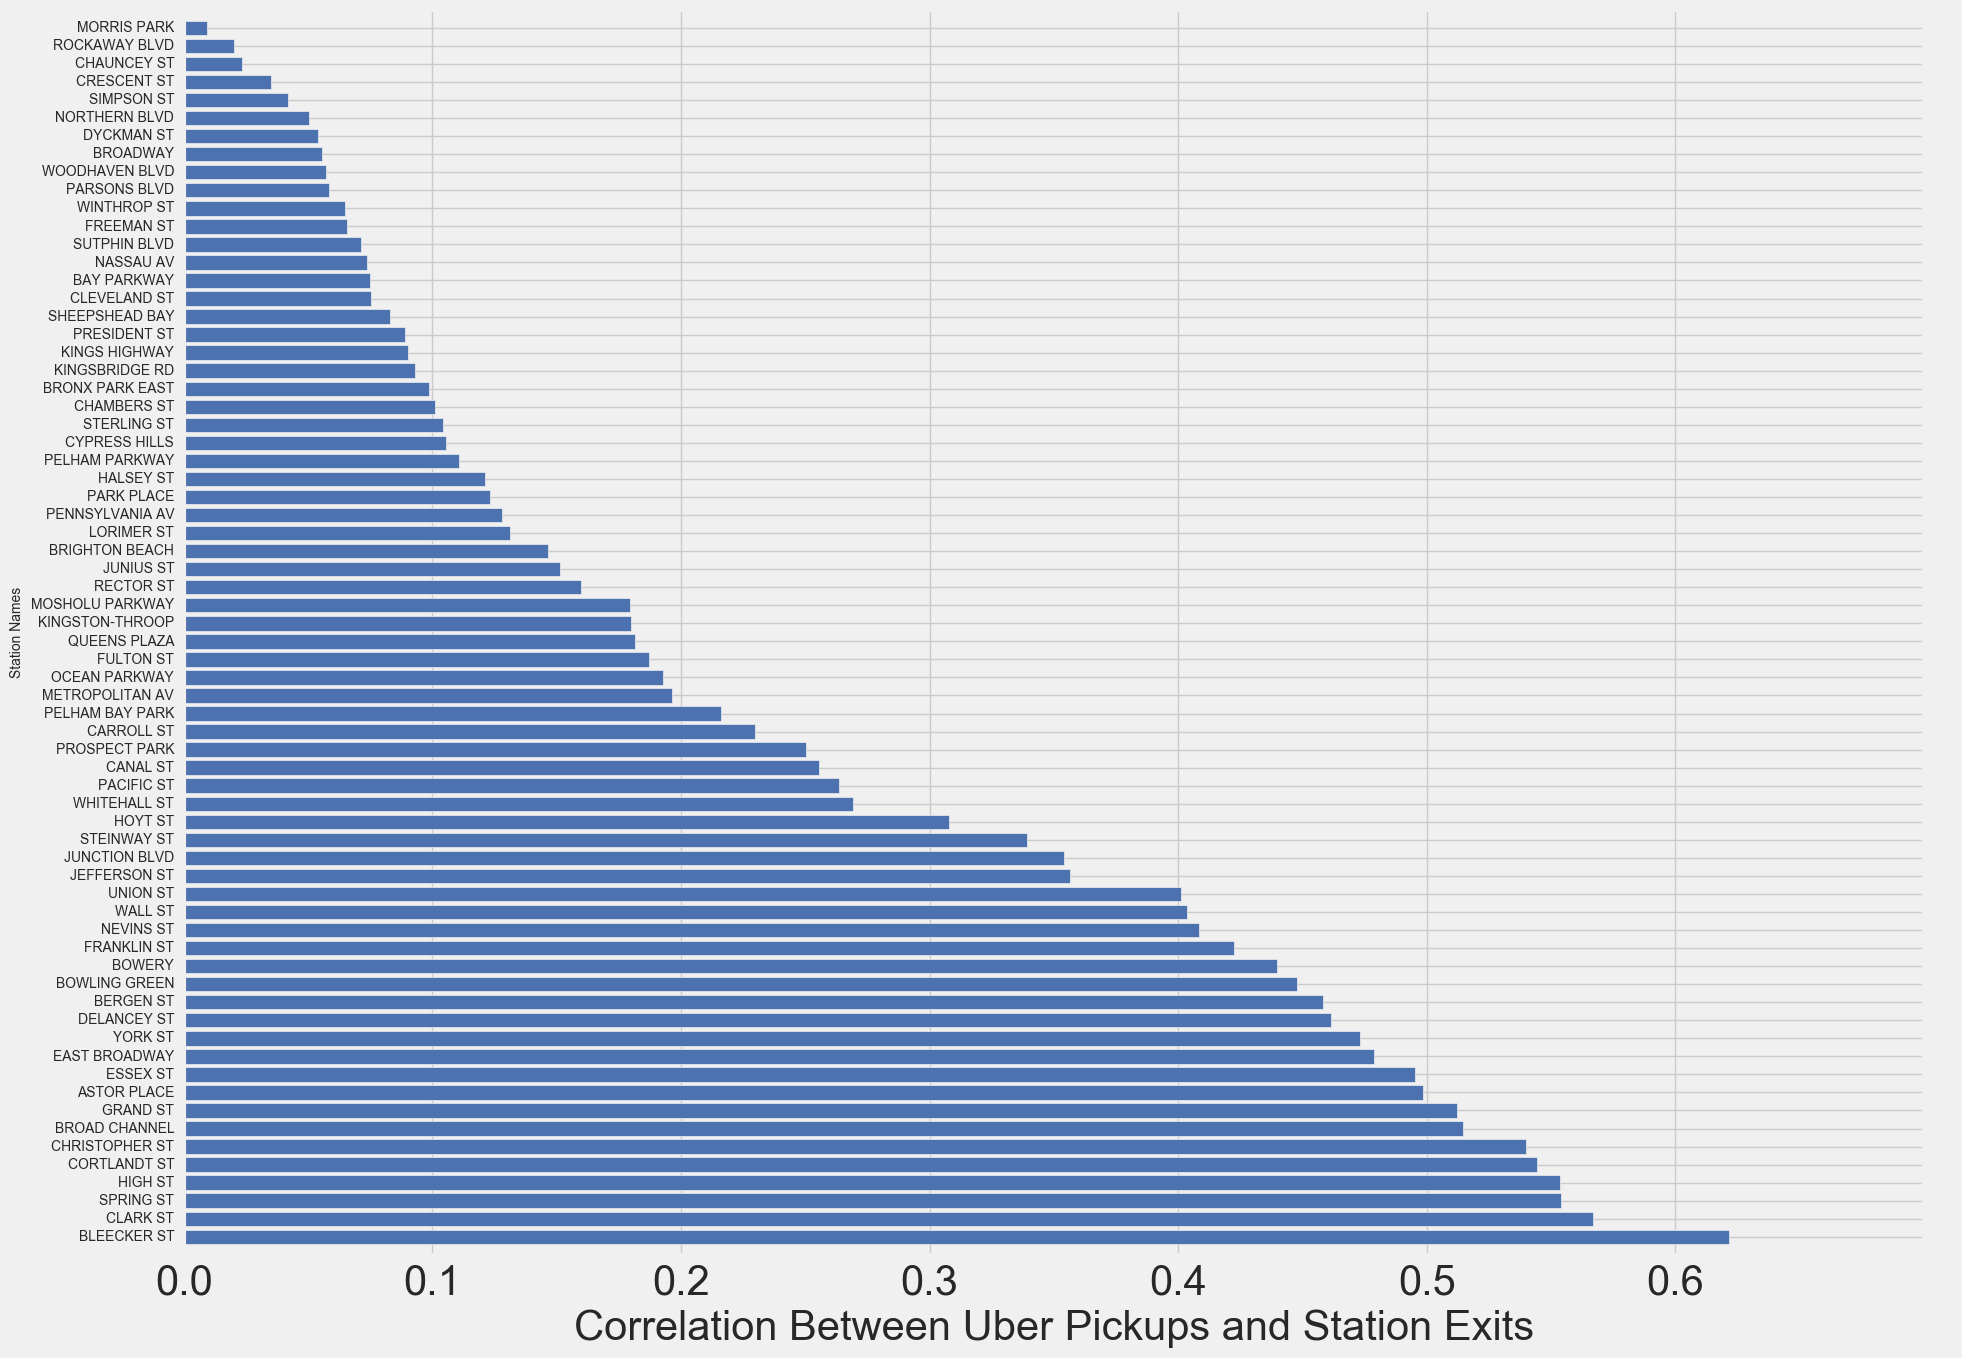

In [9]:
plt.figure(figsize=(20,15))
plt.barh(range(len(df_corr)), df_corr.Correlation, align='center')
plt.yticks(range(len(df_corr)), df_corr.Station, fontsize = 10)
plt.ylabel('Station Names', fontsize = 10)
plt.xlabel('Correlation Between Uber Pickups and Station Exits',fontsize = 30)
plt.ylim(-1,len(df_corr))
plt.xticks(fontsize = 30)
plt.xlim(0.0,0.7)

In [53]:
# Loading the Uber pickups data and their closest stations:
with open('UberData/UberStationPickups.pickle') as file: 
    datalist = pickle.load(file)
    pickups = datalist[0]

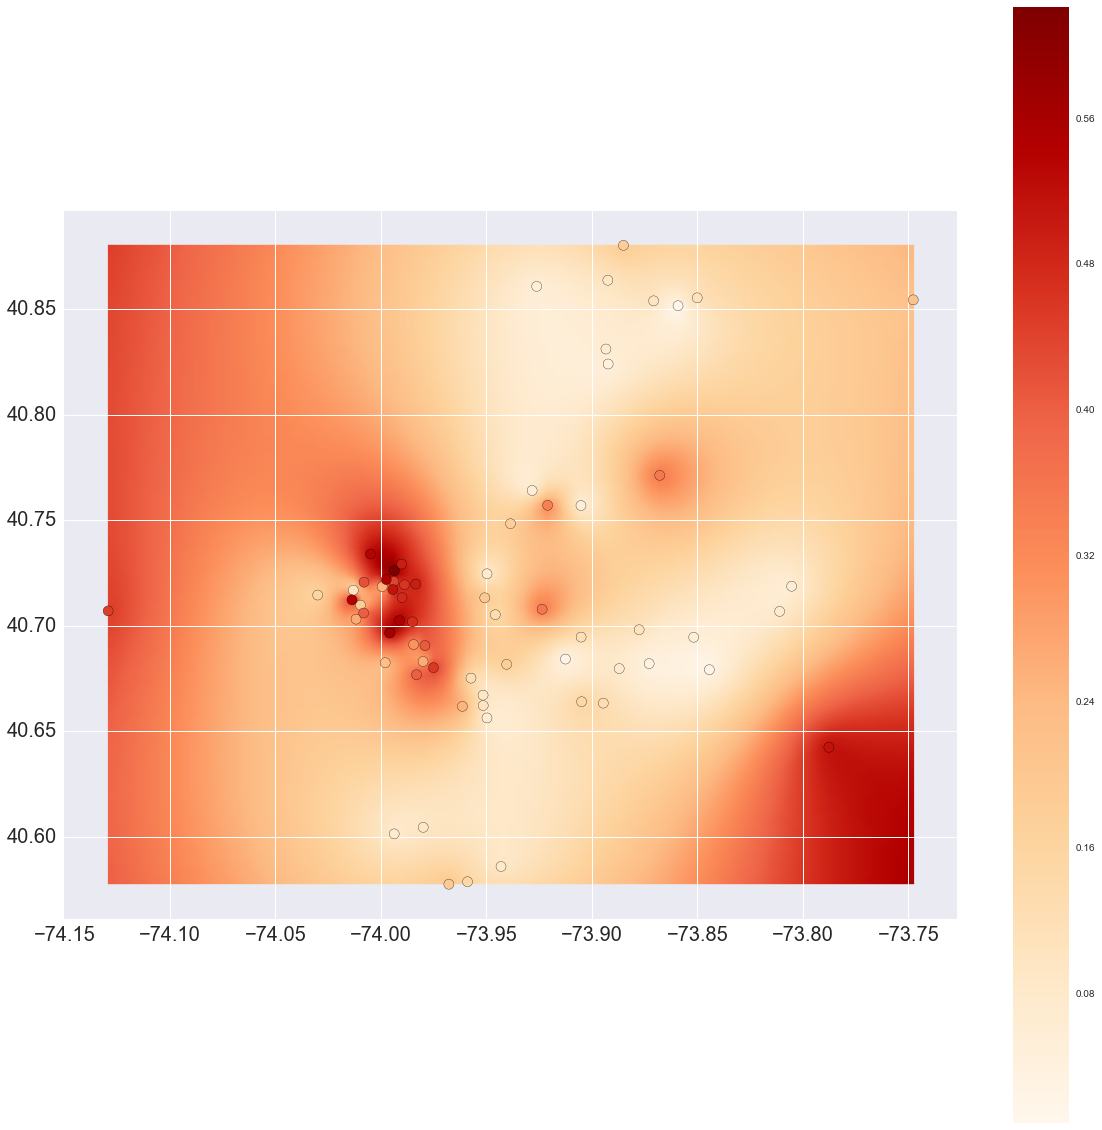

In [106]:
lat = []
lon = []
corr = []
for key in stationslist:
    if key in Correlations:
        lat.append( pickups[pickups.Closest_Station == key].Lat.mean() )
        lon.append( pickups[pickups.Closest_Station == key].Lon.mean() )
        corr.append(Correlations[key])
y,x,z = np.array(lat),np.array(lon),np.array(corr)
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

plt.figure(figsize=(20,20))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()],cmap=plt.cm.OrRd)
plt.scatter(x, y, c=z,s=100,cmap=plt.cm.OrRd)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.colorbar()

In [7]:
plt.savefig('barchart.png')